In [1]:
import gc
from itertools import product
import re

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

In [2]:
def load_promoter(file):
    l = []
    with open('../data/promoter/promoters.data') as f:
        for line in f:
            record = re.split(',\\W*', line)
            l.append(record)
    x = [list(record[2].strip().upper()) for record in l]
    y = list(map(lambda y: int(y == '+'), (record[0] for record in l)))
    return x, y

x, y = load_promoter('../data/promoter/promoter.data')

# features: 57 bp


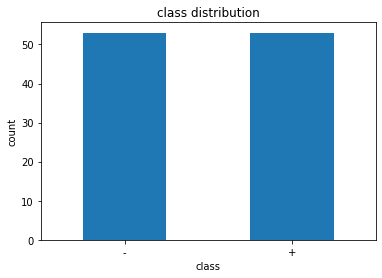

In [3]:
ax = pd.Series(y).value_counts().sort_index().plot(kind='bar')
ax.set_title('class distribution')
ax.set_xlabel('class')
ax.set_ylabel('count')
ax.set_xticklabels(['-', '+'])
ax.tick_params(rotation=0)

print('# features:', len(x[0]), 'bp')

In [4]:
word_size = 3

words = [''.join(p) for p in product('ACGT', repeat=word_size)]
word_to_idx = {word: i for i, word in enumerate(words)}
vocab_size = len(word_to_idx)

print('vocab_size:', vocab_size)

vocab_size: 64


In [5]:
# transform word array into index array
word_to_idx_func = np.vectorize(lambda word: word_to_idx[word], otypes=[np.int8])

def x_to_encoding(x, word_size=3, region_size=2, expand=True):
    '''transform index array into one-hot encoded array'''
    # word to index
    words_ = tf.strings.ngrams(x, ngram_width=word_size, separator='').numpy()
    idx = word_to_idx_func(words_.astype('U'))
    # one-hot encode
    encoding = np.zeros((len(idx), len(word_to_idx)))
    encoding[range(len(idx)), idx] = 1
    # concat
    result = np.hstack([np.roll(encoding, -shift, axis=0)
                        for shift in range(region_size + 1)])
    if expand:
        return np.expand_dims(result, axis=-1)
    else:
        return result

# Conv2d

In [6]:
region_size = 0

assert x_to_encoding(x[0], region_size=region_size).shape == (55, 64 * (region_size + 1), 1)

x_ = np.apply_along_axis(x_to_encoding, 1, x, region_size=region_size)
y_ = pd.get_dummies(y).to_numpy(dtype='float32')

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_, y_, stratify=y)
len(x_train), len(x_test)

(79, 27)

In [8]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(64, 3, activation='relu', input_shape=x_train.shape[1:]),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 53, 62, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 26, 31, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 51584)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 51584)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6602880   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [9]:
history = model.fit(x_train, y_train, epochs=20, validation_split=0.1, verbose=0)

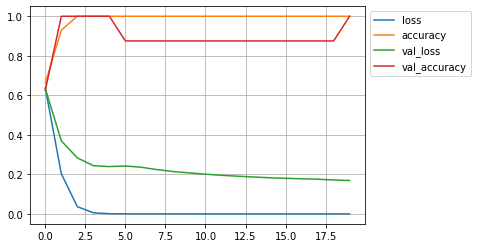

In [10]:
ax = pd.DataFrame(history.history).plot()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.grid()

In [11]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 1ms/step - loss: 0.6207 - accuracy: 0.8519


[0.62069171667099, 0.8518518805503845]

In [12]:
gc.collect()

6000

In [13]:
np.argmax(model.predict(x_test), axis=-1)

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0])

In [14]:
np.argmax(y_test, axis=-1)

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0])

# Conv1d

In [15]:
region_size = 0

assert x_to_encoding(x[0], region_size=region_size).shape == (55, 64 * (region_size + 1), 1)

x_ = np.apply_along_axis(x_to_encoding, 1, x, region_size=region_size, expand=False)
y_ = pd.get_dummies(y).to_numpy(dtype='float32')

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_, y_, stratify=y)
len(x_train), len(x_test)

(79, 27)

In [25]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv1D(64, 3, activation='relu', input_shape=x_train.shape[1:]),
    keras.layers.MaxPooling1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 53, 64)            12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 26, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 26, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               213120    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [26]:
history = model.fit(x_train, y_train, epochs=30, validation_split=0.1, verbose=0)

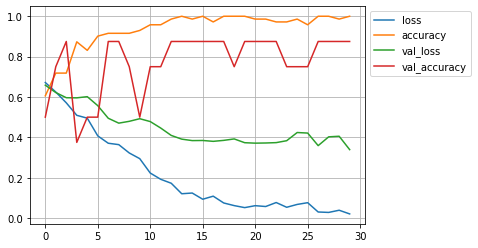

In [27]:
ax = pd.DataFrame(history.history).plot()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.grid()

In [28]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 1ms/step - loss: 0.2143 - accuracy: 0.9259


[0.21427889168262482, 0.9259259104728699]